# __이미지로 이미지 검색하기__

## __0. 데이터 세트 확인__

In [ ]:
%load_ext thanosql
%thanosql API_TOKEN={발급받은 개인 토큰}

In [79]:
%%thanosql
COPY mnist_train FROM "tutorial_data/mnist_data/mnist_train.csv"

Success


In [80]:
%%thanosql
COPY mnist_test FROM "tutorial_data/mnist_data/mnist_test.csv"

Success


## __1. 데이터 세트 확인__

손글씨 분류 모델을 만들기 위해 ThanoSQL DB에 저장되어 있는 mnist_dataset 테이블을 사용합니다. mnist_dataset 테이블은 MNIST 이미지 파일들이 저장되어 있는 경로와 파일 이름 그리고 라벨 정보가 담겨 있는 테이블입니다. 아래의 쿼리문을 실행하고 테이블의 내용을 확인합니다.

In [2]:
%%thanosql
SELECT * 
FROM mnist_train 
LIMIT 5

,img_path,filename,label
0,data/small_mnist_data/train/6782.jpg,6782.jpg,5
1,data/small_mnist_data/train/1810.jpg,1810.jpg,5
2,data/small_mnist_data/train/33617.jpg,33617.jpg,5
3,data/small_mnist_data/train/27802.jpg,27802.jpg,5
4,data/small_mnist_data/train/50677.jpg,50677.jpg,5


## __2. 이미지 수치화 모델 생성__

이전 단계에서 확인한 mnist_dataset 테이블을 사용하여 이미지 수치화 모델을 만듭니다. 아래의 쿼리 구문을 실행하여 mnist_model이라는 이름의 모델을 만듭니다.

In [5]:
%%thanosql
BUILD MODEL my_image_search_model
USING SimCLR
OPTIONS (
    image_col='img_path',    
    max_epochs=1
    )
AS 
SELECT * 
FROM mnist_train

Success


In [6]:
%%thanosql
CONVERT USING my_image_search_model
OPTIONS(
    table_name= "mnist_test",
    image_col="img_path"
    )
AS 
SELECT * 
FROM mnist_test

,image_path,filename,label,my_image_search_model_simclr
0,data/small_mnist_data/test/5099.jpg,5099.jpg,6,"[0.36851733922958374, 0.3809371292591095, 0.43..."
1,data/small_mnist_data/test/9239.jpg,9239.jpg,6,"[0.3270382881164551, 0.4070429801940918, 0.429..."
2,data/small_mnist_data/test/2242.jpg,2242.jpg,6,"[0.33250367641448975, 0.5749425888061523, 0.46..."
3,data/small_mnist_data/test/3451.jpg,3451.jpg,6,"[0.3016360104084015, 0.5699191093444824, 0.629..."
4,data/small_mnist_data/test/2631.jpg,2631.jpg,6,"[0.3470647931098938, 0.364585280418396, 0.3704..."
...,...,...,...,...
195,data/small_mnist_data/test/8045.jpg,8045.jpg,8,"[0.32833123207092285, 0.5544805526733398, 0.66..."
196,data/small_mnist_data/test/9591.jpg,9591.jpg,8,"[0.31966179609298706, 0.6303644180297852, 0.45..."
197,data/small_mnist_data/test/7425.jpg,7425.jpg,8,"[0.2210414707660675, 0.5177438259124756, 0.324..."
198,data/small_mnist_data/test/2150.jpg,2150.jpg,8,"[0.46035513281822205, 0.4369577169418335, 0.49..."


## __3. (이미지 폴더로부터) 이미지 수치화 결과 저장__

아래의 쿼리 구문을 실행하여 특정 폴더 내의 전체 이미지를 기존에 학습해 둔 모델을 사용해서 수치화 합니다. 위의 쿼리와 같은 역할을 하지만 학습을 위한 입력 데이터의 구조가 다릅니다.

In [11]:
%%thanosql
CREATE TABLE mnist_embds
USING my_image_search_model 
OPTIONS(
    path_type='folder', 
    data_type='image',
    file_type=['.jpg']
    ) 
FROM 'tutorial_data/mnist_data/test/'

Success


In [12]:
%%thanosql
SELECT * 
FROM mnist_embds 
LIMIT 5

,image_path,my_image_search_model_simclr
0,data/small_mnist_data/test/6312.jpg,"[0.35356467962265015, 0.42193669080734253, 0.3..."
1,data/small_mnist_data/test/5462.jpg,"[0.4648500084877014, 0.4455864429473877, 0.504..."
2,data/small_mnist_data/test/674.jpg,"[0.44637295603752136, 0.254580557346344, 0.499..."
3,data/small_mnist_data/test/8045.jpg,"[0.32833123207092285, 0.5544805526733398, 0.66..."
4,data/small_mnist_data/test/8100.jpg,"[0.2152605503797531, 0.432672917842865, 0.3913..."


## __4. 이미지 수치화 모델을 사용해서 유사 이미지 검색하기__

이번 단계에서는 mnist_model 이미지 수치화 모델과 mnist_embds 수치화 테이블을 사용하여 "923.jpg" 이미지 파일(손글씨 8)과 유사한 이미지를 검색합니다.

In [14]:
%%thanosql
SEARCH IMAGE images='tutorial_data/mnist_data/test/923.jpg' 
USING my_image_search_model 
AS 
SELECT * 
FROM mnist_embds

,image_path,my_image_search_model_simclr,my_image_search_model_simclr_similarity1
0,data/small_mnist_data/test/6312.jpg,"[0.35356467962265015, 0.42193669080734253, 0.3...",0.942288
1,data/small_mnist_data/test/5462.jpg,"[0.4648500084877014, 0.4455864429473877, 0.504...",0.957907
2,data/small_mnist_data/test/674.jpg,"[0.44637295603752136, 0.254580557346344, 0.499...",0.948714
3,data/small_mnist_data/test/8045.jpg,"[0.32833123207092285, 0.5544805526733398, 0.66...",0.959829
4,data/small_mnist_data/test/8100.jpg,"[0.2152605503797531, 0.432672917842865, 0.3913...",0.934777
...,...,...,...
195,data/small_mnist_data/test/7083.jpg,"[0.3092852830886841, 0.49765217304229736, 0.24...",0.947544
196,data/small_mnist_data/test/7425.jpg,"[0.2210414707660675, 0.5177438259124756, 0.324...",0.953421
197,data/small_mnist_data/test/2895.jpg,"[0.31555038690567017, 0.4576123356819153, 0.59...",0.952745
198,data/small_mnist_data/test/9001.jpg,"[0.31824254989624023, 0.3472241163253784, 0.60...",0.950983


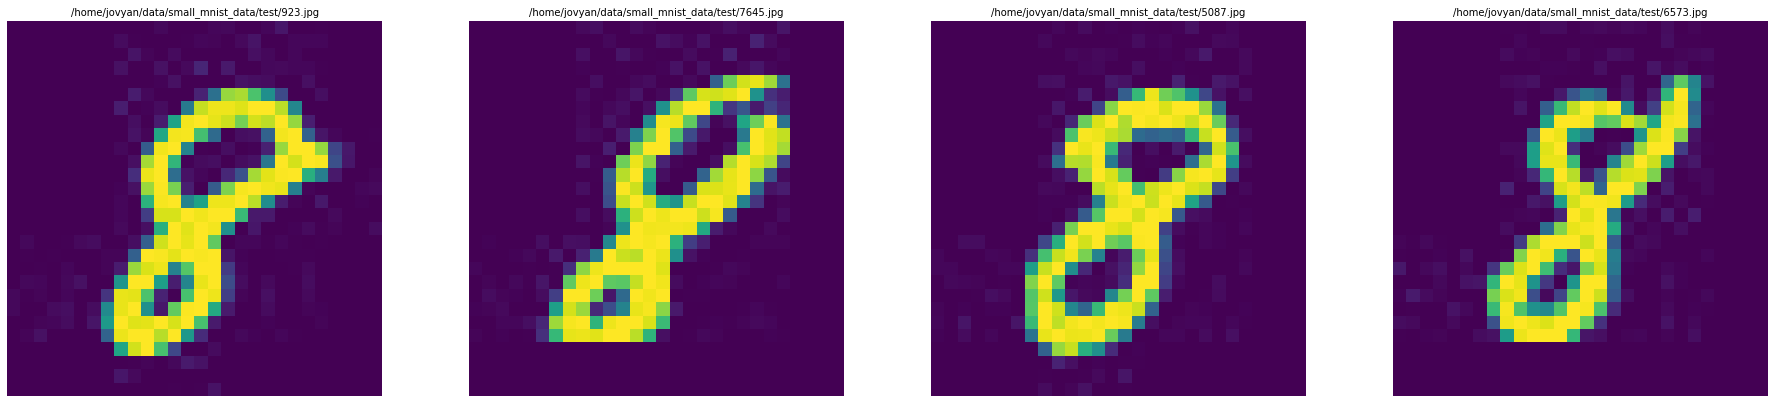

In [15]:
%%thanosql
PRINT IMAGE 
AS (
    SELECT image_path, my_image_search_model_simclr_similarity1 
    FROM (
        SEARCH IMAGE images='tutorial_data/mnist_data/test/923.jpg'
        USING my_image_search_model 
        AS 
        SELECT * 
        FROM mnist_embds
        )
    ORDER BY my_image_search_model_simclr_similarity1 DESC 
    LIMIT 4
    )